In [ ]:
# # Building alternative pipeline
# 
# * Prepare Hough transform based only on wire information (= energy, time, radial distance)
# * Build predictions based on Hough, local information, and local information of left/right neighbors
# 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import CyDetHits
hits = CyDetHits('../data/signal_TDR.root', branches="mt", signal_coding=[0])

In [3]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
right_neighs = numpy.array([hits.geom.shift_wire(wire, 1) for wire in range(hits.geom.n_points)])
left_neighs = numpy.array([hits.geom.shift_wire(wire, -1) for wire in range(hits.geom.n_points)])

In [5]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.geom.point_rhos for i in range(hits.n_events))

In [6]:
labels.shape, deposits.shape

((3444, 4482), (3444, 4482))

In [7]:
def flatten_data(data, keys, samples, n_features):
    data_flat = data[samples].reshape(-1, n_feats)
    return pandas.DataFrame(data=data_flat, columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, hits.geom.n_points)
    
    return pred, pred_evt

In [8]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(hits.n_events*hits.geom.n_points).reshape(hits.n_events, -1)

In [9]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

In [10]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id

# LR-Neighbour Features
features['r_deposit'] = (deposits * 100)[:, right_neighs]
features['r_rel_time'] = rel_time[:, right_neighs]
features['l_deposit'] = (deposits * 100)[:, left_neighs]
features['l_rel_time'] = rel_time[:, left_neighs]

# Truth values
features['labels'] = labels
features['is_signal'] =  numpy.take([0, 1, 0], labels)

In [11]:
# Define Data
train_features = features.keys()[:-2]
data = numpy.dstack(features.values())
n_feats = data.shape[-1]
print data.shape

(3444, 4482, 9)


In [12]:
data_1, data_2, data_3 = [flatten_data(data, features.keys(), samp, n_feats) 
                          for samp in [sample_1, sample_2, sample_3]]

In [13]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [14]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [15]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 119.27 seconds
Totally spent 119.27 seconds on training


In [16]:
print np.unique(labels)

[0 1 2]


In [17]:
# Print these predictions
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

In [18]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

In [19]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.997619006833
0.277418916119


In [21]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = hits.geom.point_pol != 1
odd_wires = hits.geom.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(hits.geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax, sig_rho_sgma=rsgma)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [22]:
# Check the shape, and the number of non-zero entries
new_correspondence.shape, new_correspondence.nnz


# ## Rotation of Even Layers from Hough Output

# In[40]:

def plot_hough_shift(int_even, int_odd, this_phi, savedir=None):
    dphi = (2.*np.pi)/len(int_even)
    phi_bins = dphi*np.arange(len(int_even))
    plt.bar(phi_bins, int_even, alpha=0.5, width=dphi)
    plt.bar(phi_bins, int_odd, color="red",alpha=0.5, width=dphi)
    plt.title(r"Track Center Weights vs. $\phi$")
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"Track Center Weights (Integrated over $\rho$)")
    plt.xlim([0,2*np.pi])
    if savedir != None:
        plt.savefig(savedir+"hough_by_phi.png")
    show()
    plt.bar(phi_bins, int_even, alpha=0.5, width=dphi)
    plt.bar(np.roll(phi_bins, this_phi), int_odd, color="red",alpha=0.5, width=dphi)
    plt.title(r"Shifted Track Center Weights vs. $\phi$")
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"Track Center Weights (Integrated over $\rho$)")
    plt.xlim([0,2*np.pi])
    if savedir != None:
        plt.savefig(savedir+"s_hough_by_phi.png")
    show()

In [23]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     pred_evt_2, alpha_max=2., alpha_rw=2.)

In [24]:
# Predict for third sample
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

In [25]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_2 = aligner.transform(pred_evt_2)
_ , to_align_3 = aligner.transform(pred_evt_3)

In [26]:
# Shift this hough space to get the even and odd layers agreeing
hough_shifter_2 = HoughShifter(hough, 10, -10)
hough_shifter_3 = HoughShifter(hough, 10, -10)

# Get the images
hough_image_even_3 = to_align_3[:,:hough.track.n_points]
hough_image_odd_3 = to_align_3[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_3, integral_even_3, integral_odd_3 =\
    hough_shifter_3.fit_shift(hough_image_even_3, hough_image_odd_3)
# Shift the result
shift_pred_evt_3 = hough_shifter_3.shift_result(pred_evt_3)
shift_labels_3 = hough_shifter_3.shift_result(features['labels'][sample_3])

# Get the images
hough_image_even_2 = to_align_2[:,:hough.track.n_points]
hough_image_odd_2 = to_align_2[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_2, integral_even_2, integral_odd_2 =\
    hough_shifter_2.fit_shift(hough_image_even_2, hough_image_odd_2)
# Shift the result
shift_pred_evt_2 = hough_shifter_2.shift_result(pred_evt_2)

../modules/tracking.py:498: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  assert self.rotate_index != None,\


In [27]:
# Hough Transform on the shifted results
shifted_hough_result_3, shifted_hough_image_3 = hough_transformer.transform(shift_pred_evt_3)
shifted_hough_result_2, shifted_hough_image_2 = hough_transformer.transform(shift_pred_evt_2)

# Unshift the results to add them as a feature
unshifted_hough_result_3 = hough_shifter_3.shift_result(shifted_hough_result_3, backward=True)
unshifted_hough_result_2 = hough_shifter_2.shift_result(shifted_hough_result_2, backward=True)

In [28]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_2['Shift_Hough'] = unshifted_hough_result_2.flatten()

data_3['Hough'] = hough_result_3.flatten()
data_3['Shift_Hough'] = unshifted_hough_result_3.flatten()

In [29]:
# Add this to the feature list
train_features_full = train_features + ['Hough']
train_features_shift = train_features + ['Shift_Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

s_hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_shift) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Shift Hough, Local and Neighbour Features', s_hough_gbdt)
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [30]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 239.08 seconds
model Shift Hough, Local and Neighbour Features was trained in 126.03 seconds
model Hough, Local and Neighbour Features was trained in 127.90 seconds
model Energy Deposition was trained in 64.04 seconds
Totally spent 557.05 seconds on training


In [31]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_final_shift_3, pred_final_shift_evt_3 = predict_classifier(s_hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

In [32]:
# TODO clean this up
figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$"),
            ('Shift_Hough' , r"Shift Hough, $W_j'''$"),
        ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

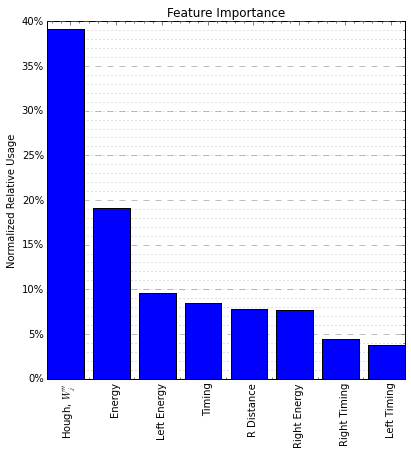

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


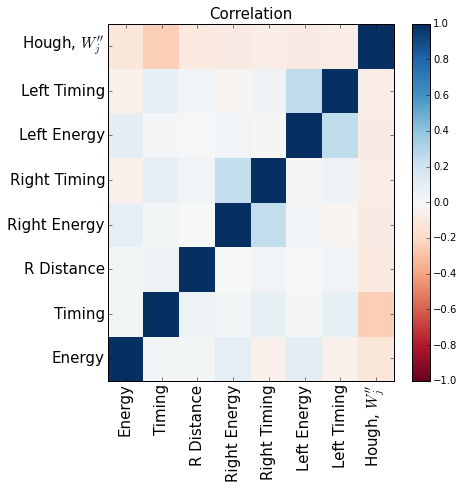

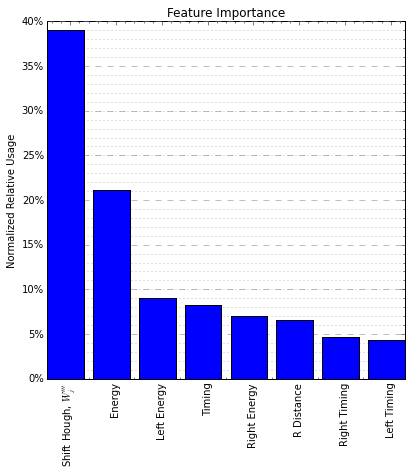

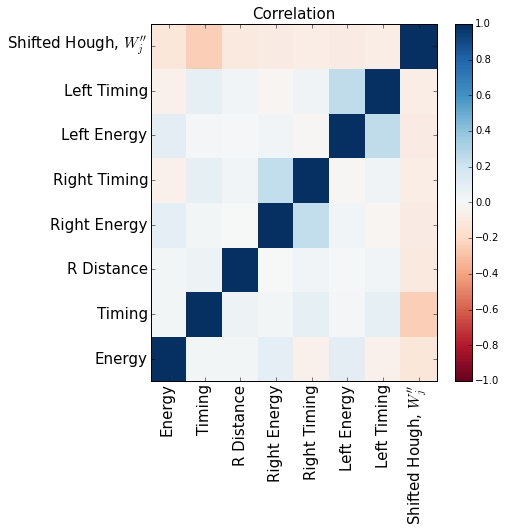

In [33]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

feat_label_dict['Hough'] = r"Shifted Hough, $W_j''$"
s_hough_level = factory["Shift Hough, Local and Neighbour Features"]
plot_feature_importance(s_hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()


(<matplotlib.axes._subplots.AxesSubplot at 0x23bec290>,
 <matplotlib.figure.Figure at 0x23c08150>)

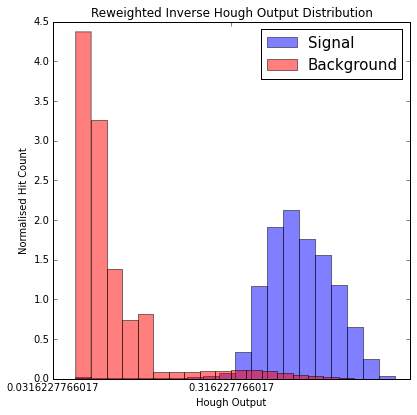

In [34]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x23c08ad0>,
 <matplotlib.figure.Figure at 0x251f5790>)

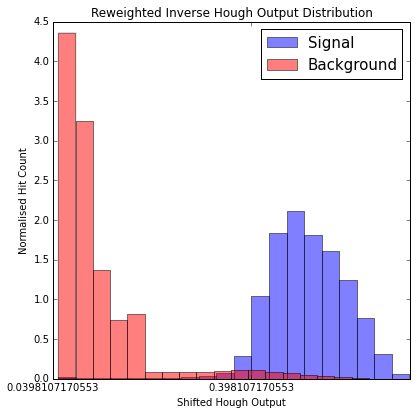

In [35]:
plot_feature( (data_3['Shift_Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Shifted Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [36]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)

0.999501379669
0.99950516744


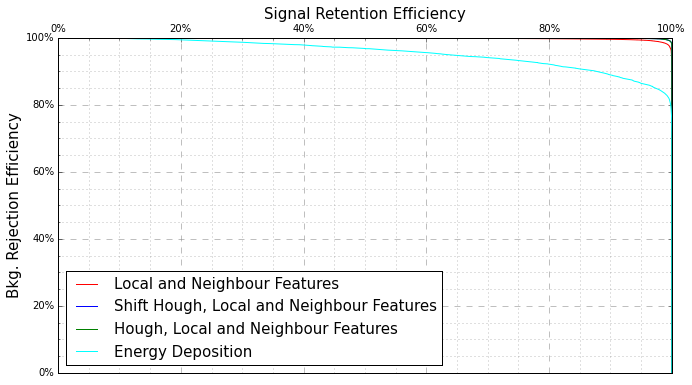

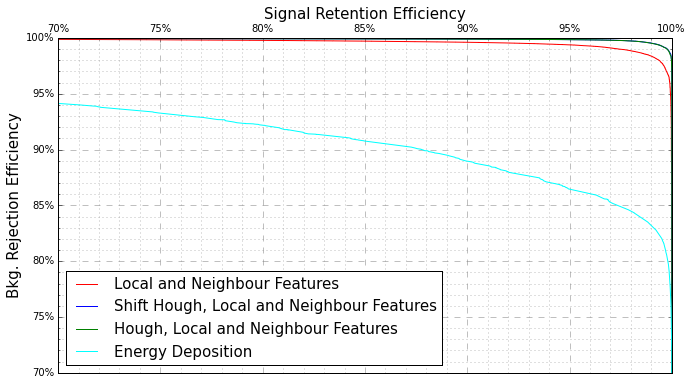

In [37]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

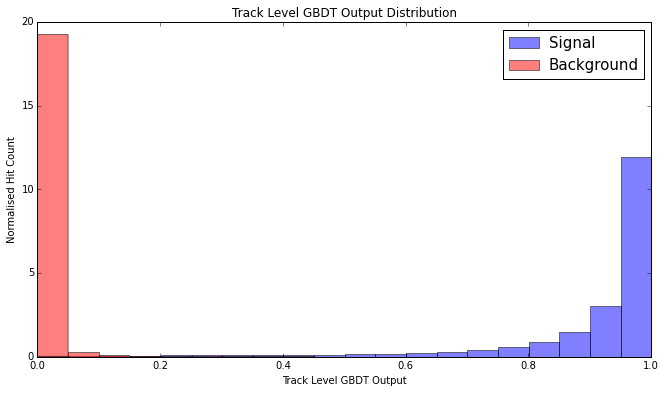

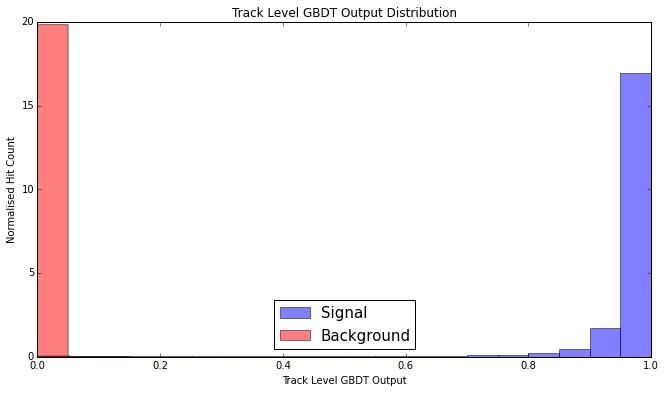

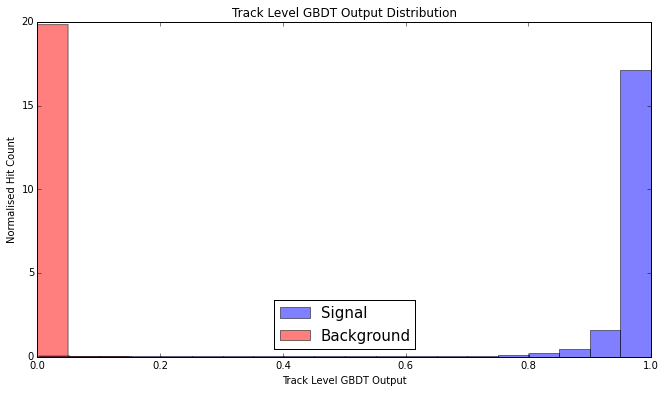

In [38]:
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_shift_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [39]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.998401801477
0.219121194944


In [40]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_final_shift_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_shift_3, sample_weight=problem_weights_3)

0.99950516744
0.116085270938


In [41]:
from sklearn import linear_model
#print linear_model.LinearRegression__doc__
#print linear_model.RANSACRegressor.__doc__

In [42]:
# Get the actual circle parameters for the fit from the linearized parameters
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [43]:
# Check that the fit returns a circle that passes through the production target
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [44]:
# Geometric considerations for the fit
wire_x, wire_y = hits.geom.get_points_xs_and_ys()
# Linearize the input problem
wire_xy = np.vstack([wire_x, wire_y]).T
wire_z  = np.square(wire_x) + np.square(wire_y)

In [45]:
def ransac_fit(labels, preds, min_hits=13, plot=False):
    # Initialze parameters
    x1, y1, r1 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    x2, y2, r2 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    this_score = -1.*np.ones(wire_z.shape[0])
    
    # Get wires to fit
    even_sig = even_wires & preds
    odd_sig = odd_wires & preds
    
    # Plot the input to the fit
    if plot:
        plot_output(to_plot, hits.geom, size=40*preds)
        plot_add_outlines(to_plot, hits.geom)

    # Skip if either layer does not have enough hit points
    # if (sum(even_sig) < min_hits) or (sum(odd_sig) < min_hits):
    #     print "Skipped"
    #    if plot:
    #        show()
    #    return

    for pol, signal in enumerate([even_sig, odd_sig]):

        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        try:
            model.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped Normal"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                                   is_model_valid=inside_target,
                                                   max_trials=1000)
        try:
            model_ransac.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped RANSAC"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        inlier_mask = signal[model_ransac.inlier_mask_]
        outlier_mask = signal[np.logical_not(model_ransac.inlier_mask_)]

        # Plot the output
        labels = np.zeros(hits.geom.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2

        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)

        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)

        # Make sure we're plotting all points
        assert len(inlier_mask) + len(outlier_mask) == sum(signal),            "{} {}".format(len(inlier_mask) + len(outlier_mask), len(signal))    
        if plot:
            plot_add_circle(x1[pol], y1[pol], r1[pol])
            print "Fit:" + str(r1[pol])
            plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
            print "RANSAC Fit:" + str(r2[pol]) + "\n"

        # Score the wires by distance from RANSAC
        this_score = model_ransac.estimator_.predict(wire_xy)[:,0]
        this_score -= wire_z
        this_score = np.absolute(this_score)
    if plot:
        show()
    return x1, y1, r1, x2, y2, r2, this_score

In [46]:
# Define threshold GBDT output to fit to
fpr, tpr, values =  roc_curve(mask(data_3)['is_signal'], pred_final_3)
threshold = np.where(tpr > 0.99)[0][0]
print "TPR: {}".format(tpr[threshold]),      "FPR: {}".format(fpr[threshold]),      "VALUE: {}".format(values[threshold])

# Define the wires to be fit and their locations
cut_pred_final_3 = pred_final_evt_3 > values[threshold]
fit_evts = cut_pred_final_3.shape[0]

TPR: 0.99000602047 FPR: 0.00469918008278 VALUE: 0.316766667385


In [47]:
# Score the wires by distance from RANSAC
score = np.zeros(data_3['labels'].shape[0]) 
for evt in range(len(sample_3)):
    if evt%100 == 0:
        print evt
    evt_hits = event_to_hit_look[evt]
    to_fit = data_3["labels"].values[evt_hits]
    output = ransac_fit(to_fit, cut_pred_final_3[evt,:])
    if output != None:
        score[evt_hits] =  output[-1]
data_3['score'] = score

0
100
200
300
400
500
600
700
800
900
1000


/usr/lib64/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [48]:
good_events = data_3[data_3['score'] != -1].shape[0]/4482
total_events = data_3.shape[0]/4482
print good_events/float(total_events)

0.931334622824


/home/elg112/.local/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


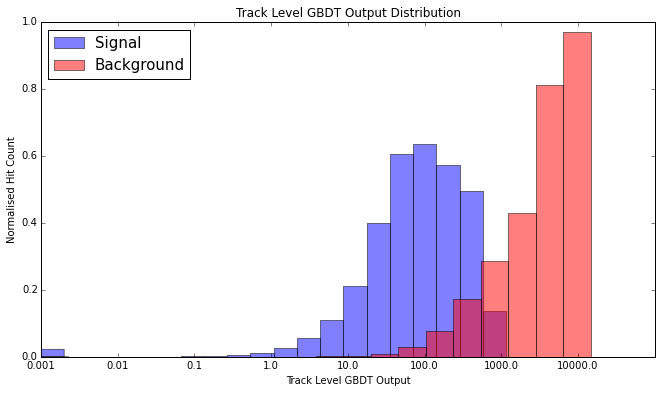

In [49]:
plot_feature((mask(data_3)[data_3['score'] != -1]['score'].values +0.001), 
             mask(data_3)[data_3['score'] != -1]['labels'].values, xlog=True,
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [50]:
# Event information\
event = 7
add_trans = True
save = False
savedir = "/home/elg112/COMET/Presentations_Papers/HEP_Summer_School/images/algorithm_0/"

evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot information
shift_plot = shift_labels_3[event]
shift_hough_output = shifted_hough_result_3[event,:]
shift_hough_image = shifted_hough_image_3[event,:hough.track.n_points] +\
                    shifted_hough_image_3[event,hough.track.n_points:]

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


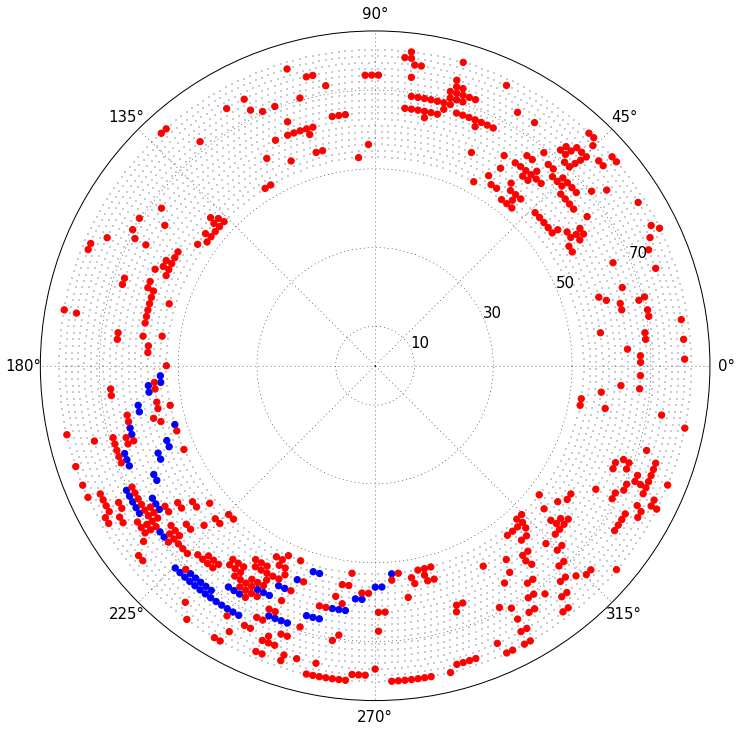

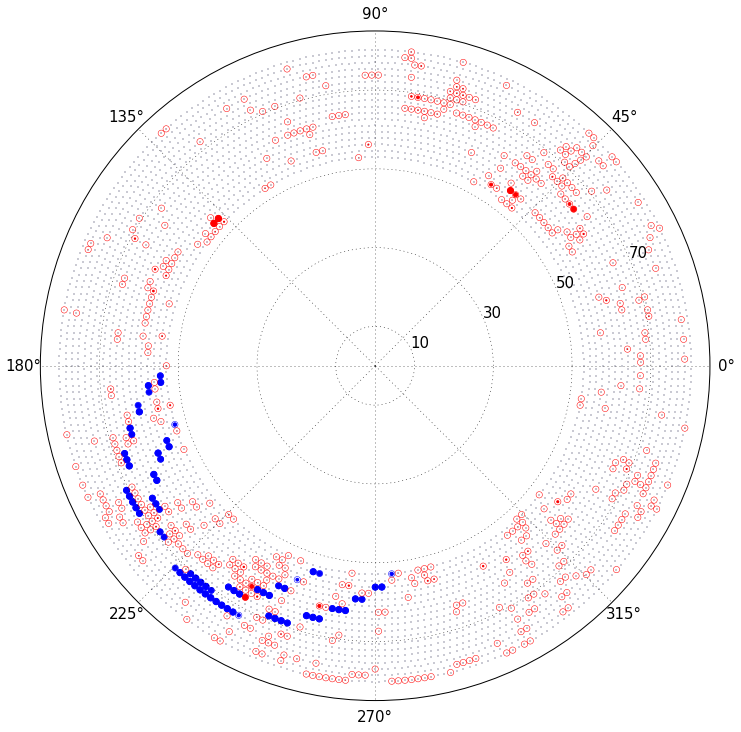

Length of draw tracks are 90


/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


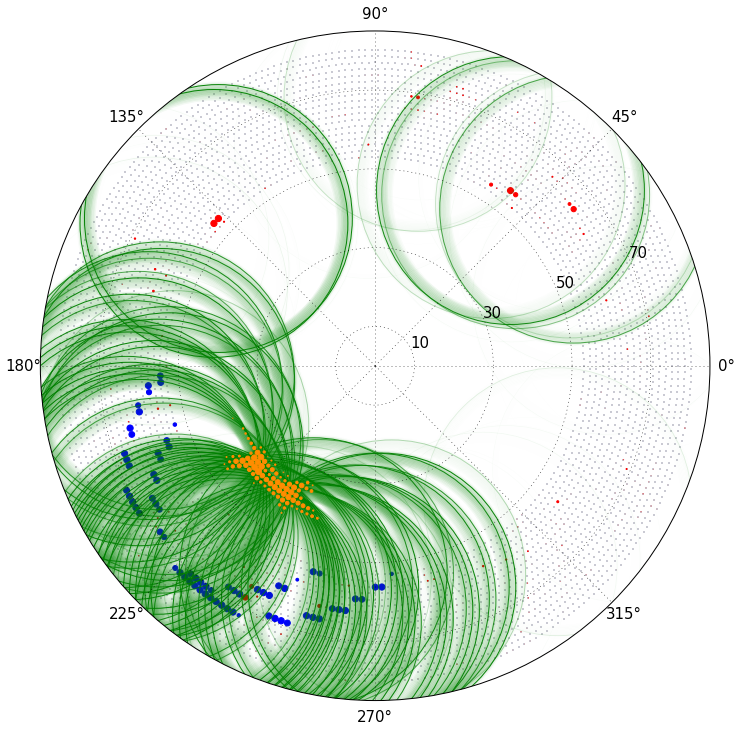

Length of draw tracks are 90


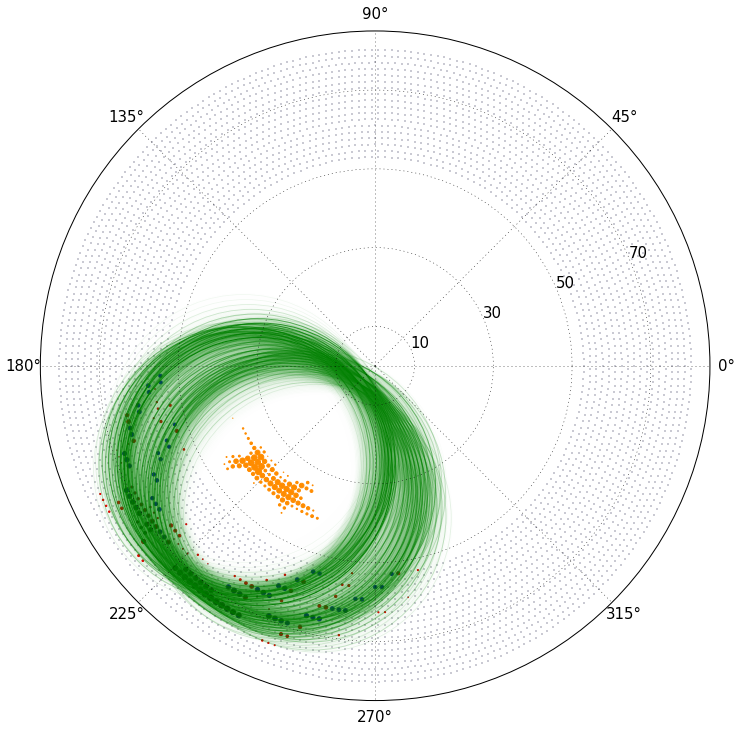

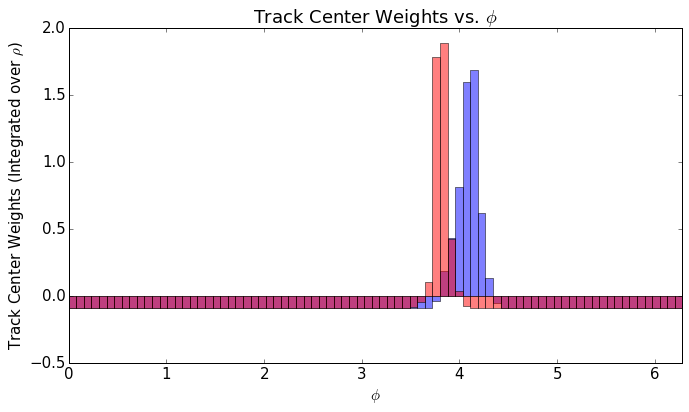

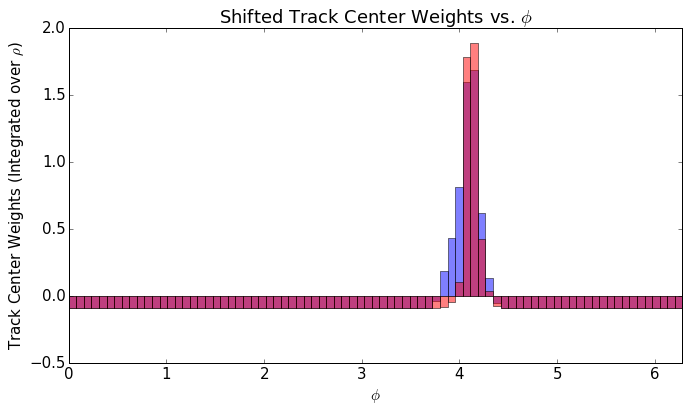

Length of draw tracks are 78


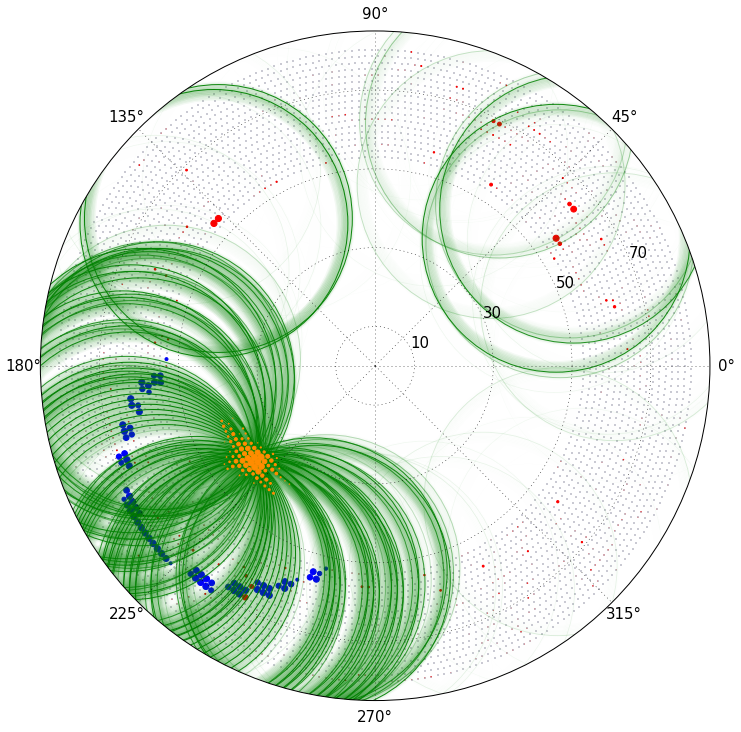

Length of draw tracks are 80


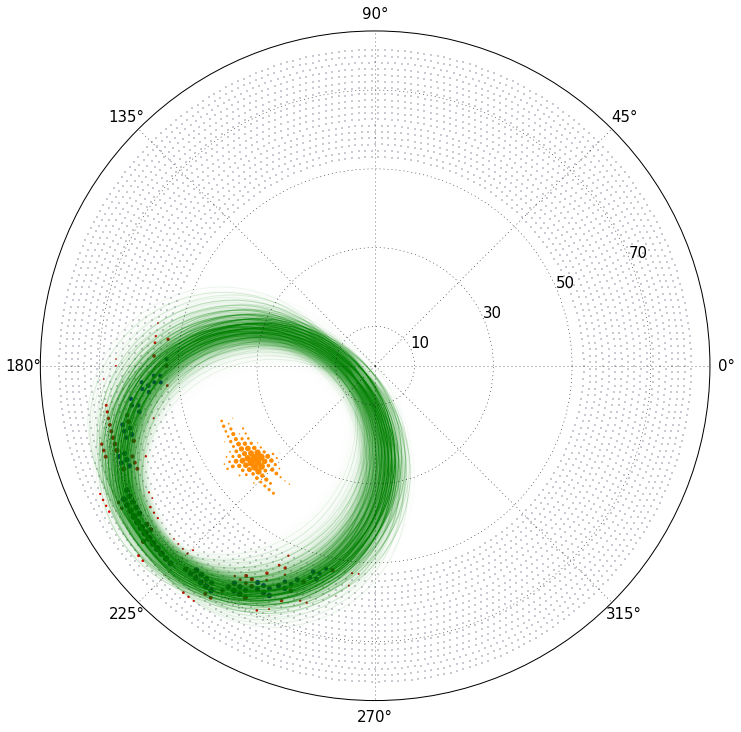

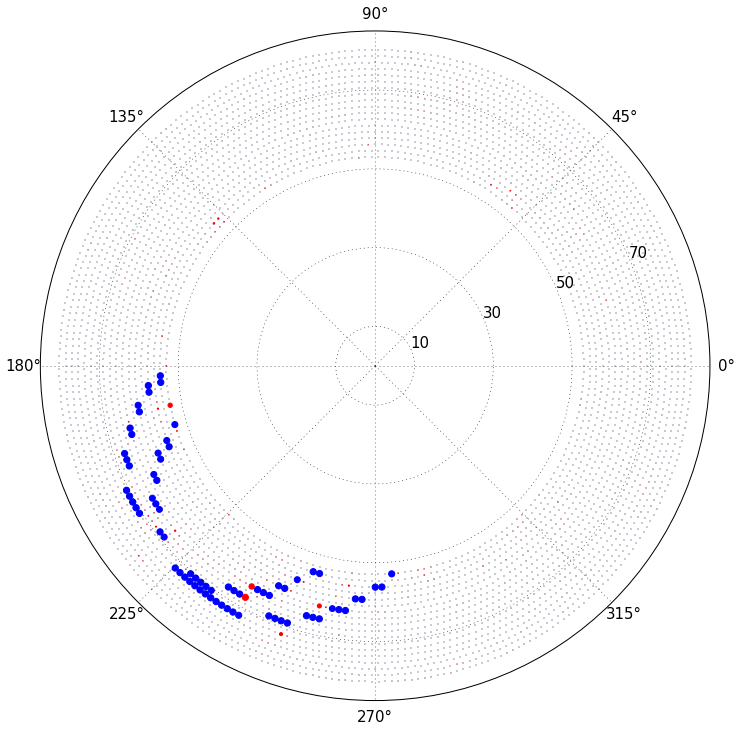

Fit:33.4919804163
RANSAC Fit:33.4919804163

Fit:32.0354858099
RANSAC Fit:32.0354858099



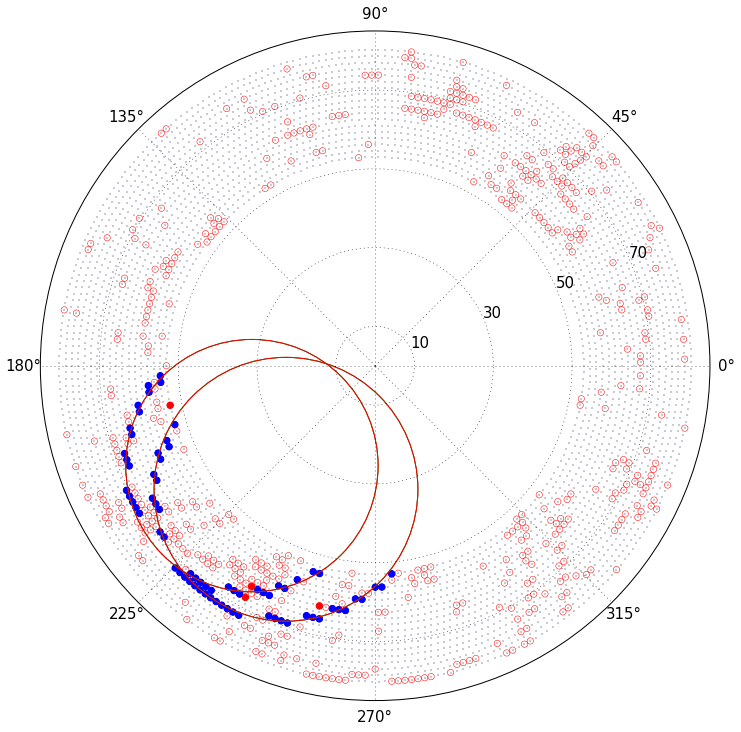

(array([-22.6351962 , -31.28324532]), array([-31.35837389, -25.35284914]), array([ 33.49198042,  32.03548581]), array([-22.6351962 , -31.28324532]), array([-31.35837389, -25.35284914]), array([ 33.49198042,  32.03548581]), array([  6720.16004939,   6803.75628408,   6883.92938935, ...,
        11826.22784092,  11915.70124153,  12003.03037342]))


In [51]:
# Basic output
plot_output(to_plot, hits.geom)
show()

# First GBDT output
plot_output(to_plot, hits.geom, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, hits.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, hits.geom, size=plot_norm_size(pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(hits.geom, hough, size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, hits.geom, size=plot_norm_size(hough_output))
plot_add_tracks(hits.geom, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], 
                 hough_shifter_3.rotate_index[event]+hough_shifter_3.lower_lim, 
                 savedir=savedir)
show()

# Hough output
plot_output(shift_plot, hits.geom, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(hits.geom, hough, size=plot_norm_size(shift_hough_image,40))
if save:
    plt.savefig(savedir+"plot_shft_hough.png",  bbox_inches='tight')
show()

# Inverse Hough output
plot_output(shift_plot, hits.geom, size=plot_norm_size(shift_hough_output))
plot_add_tracks(hits.geom, hough, size=plot_norm_size(shift_hough_image,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_shft_inv_hough.png")
show()

# Final
plot_output(to_plot, hits.geom, size=plot_norm_size(pred_final_evt_3[event,:]))
if save:
    plt.savefig(savedir+"plot_shft_inv_hough.png")
show()

# RANSAC 
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True)

In [ ]:

# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

